In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
import import_ipynb
from hall_data import doping, anneal

importing Jupyter notebook from hall_data.ipynb


# Get image data

In [2]:
sample_datafile = '../data/rho_c/sample_images/data.pkl'
image_df = pd.read_pickle(sample_datafile)

Filter out TNO data

In [3]:
image_df = image_df[image_df.apply(lambda x: 'TNO' not in x['sample name'], axis = 1)]
#image_df = image_df[image_df.apply(lambda x: 'pSi' in x['sample name'], axis = 1)]
#image_df = image_df[image_df.apply(lambda x: 'r96' in x['sample name'] or 'r48' in x['sample name'], axis = 1)]

Handle sample names

In [4]:
def extract_parameters(x):
    keys = ['substrate', 'doping', 'anneal']
    values = x['sample name'].split('_')[:3]
    res = dict(zip(keys, values))
    piece = 'piece' + str(int(x.piece))
    res['piece'] = piece
    return pd.Series({**x, **res})

image_df = image_df.apply(extract_parameters, axis = 1)

Calculate sample area.

In [5]:
COIN_RADIUS = 20.25 /(2*10) # cm (diameter to radius, mm to cm)
REFERENCE_AREA = np.pi*COIN_RADIUS**2 # cm^2

def get_area(x):
    return REFERENCE_AREA*x['pixels']/x['ref pixels']

image_df = image_df.assign(area = get_area)

# Get IVt data

In [6]:
IVt_folder = '../data/rho_c/'
sys.path.append(IVt_folder)
import getData
rho_df = getData.get_all_data()

Fit measured resistance.

In [7]:
def fit_resistance(x):
    data = x.data
    [[R]] = LinearRegression().fit(data.I.values.reshape(-1,1),
                              data.V.values.reshape(-1,1)).coef_
    return R

rho_df = rho_df.apply(lambda x: pd.Series({**x, 'R' : fit_resistance(x)}), axis = 1)

# Merge image and resistance data

In [8]:
full_df = rho_df.merge(image_df, 
                       on = ['substrate', 'doping', 'anneal', 'piece'],
                       #how = 'outer',
                      )
full_df.doping = full_df.doping.astype(doping)
#full_df.anneal = full_df.doping.astype(anneal)
full_df = full_df.assign(rho_s = lambda x: x.R*x.area)
full_df = full_df.assign(rho_c = lambda x: x.rho_s/2)

In [9]:
df = full_df[['piece','substrate', 'doping', 'anneal', 'R', 'area', 'rho_c']]
df

,piece,substrate,doping,anneal,R,area,rho_c
0,piece1,260nplus,r96,500C,0.180149,0.692040,0.062335
1,piece0,pSi,r96,400C,14.729864,1.643191,12.101989
2,piece0,pSi,r96,400C,14.729864,0.628605,4.629632
3,piece1,130nplus,r48,400C,0.116467,0.807406,0.047018
4,piece1,130nplus,r48,400C,0.130697,0.807406,0.052763
5,piece2,260nplus,r96,500C,0.232481,0.484703,0.056342
6,piece2,pSi,r96,400C,0.086218,1.180719,0.050900
7,piece0,pSi,int,500C,21.422518,0.565777,6.060188
8,piece2,pSi,r48,400C,0.181506,0.460208,0.041765
9,piece0,130nplus,int,500C,4.642957,0.804629,1.867929


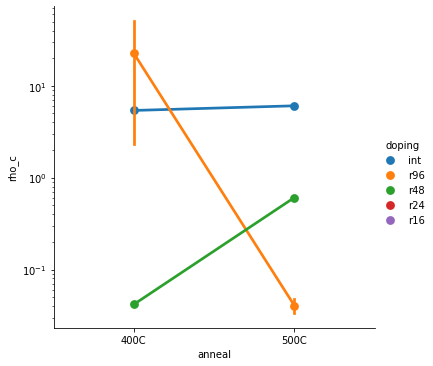

In [10]:
if __name__ == "__main__":
    import seaborn as sns
    p = sns.catplot(x = 'anneal', y = 'rho_c', hue = 'doping', kind = 'point', data = full_df[full_df.substrate == 'pSi'])
    p.set(yscale = 'log')

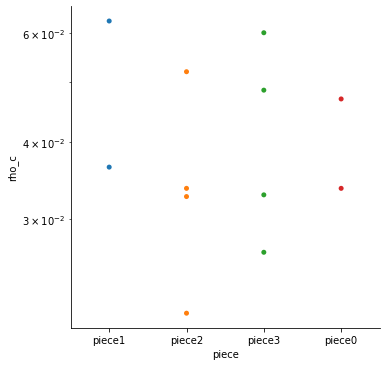

In [11]:
p = sns.catplot(
    data = (df
            #.assign(lbl = lambda data: pd.Series(list(zip(data.anneal, data.doping, data.substrate))).astype(pd.CategoricalDtype())),
            .assign(lbl = lambda d: d.substrate.str.cat(others = [d.doping, d.anneal], sep = ' '))
            .query('doping == "r96" and substrate == "pSi" and anneal == "500C"')
           ),
    x = 'piece',
    y = 'rho_c',
    #hue = 'piece',
    # col = 'substrate',
    kind = 'swarm',
)

p.set(
    yscale = 'log',
    #ylim = [0, None],
)

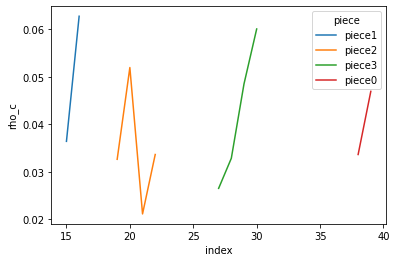

In [12]:
data = (df
            #.assign(lbl = lambda data: pd.Series(list(zip(data.anneal, data.doping, data.substrate))).astype(pd.CategoricalDtype())),
            .assign(lbl = lambda d: d.substrate.str.cat(others = [d.doping, d.anneal], sep = ' '))
            .query('doping == "r96" and substrate == "pSi" and anneal == "500C"')
           )

p = sns.lineplot(
    data = data.reset_index(),
    x = 'index',
    y = 'rho_c',
    hue = 'piece',
)